## Importing Libraries

In [1]:
import os
import math
import cv2
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import h5py
from keras import layers
from lrfinder import LRFinder
from PIL import Image, ImageOps
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
import seaborn as sns
from skimage import io

In [3]:
from tensorflow.keras.applications.resnet import ResNet50

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import BatchNormalization, Dropout

In [5]:
from tensorflow.keras.models import load_model

In [6]:
import h5py
print(h5py.__version__)

2.10.0


## Data Preprocessing 

### Data Augmentation

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [8]:
input_size = (160,160)
batch_size = 64

In [9]:
training_set = train_datagen.flow_from_directory('Data/Custom/Split/augmented_train',
                                                 target_size = input_size,
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('Data/Custom/Split/validation',
                                            target_size = input_size,
                                            batch_size = batch_size,
                                            class_mode = 'categorical')


Found 1535 images belonging to 14 classes.
Found 145 images belonging to 14 classes.


## FaceNet Model

In [10]:
model = load_model('facenet_keras.h5')

print(model.inputs)
print(model.outputs)

2022-06-02 22:07:46.669004: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-02 22:07:46.670749: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


[<tf.Tensor 'input_1:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/Identity:0' shape=(None, 128) dtype=float32>]


In [11]:
model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

In [12]:
set_trainable = False
for layer in model.layers:
    if layer.name[:6] == 'Block8':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [13]:
new_model = Sequential()
new_model.add(model)
new_model.add(Dropout(0.5))
new_model.add(Dense(14,activation='sigmoid'))

In [14]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v1 (Model)  (None, 128)               22808144  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 14)                1806      
Total params: 22,809,950
Trainable params: 9,831,310
Non-trainable params: 12,978,640
_________________________________________________________________


In [15]:
from tensorflow.keras.optimizers import Adam

new_model.compile(optimizer = Adam(0.00075), 
              loss ="categorical_crossentropy", 
              metrics =["categorical_accuracy"])


In [16]:
history = new_model.fit(training_set, epochs = 40, validation_data = test_set)

Train for 24 steps, validate for 3 steps
Epoch 1/40
24/24 [==============================] - 451s 19s/step - loss: 2.1506 - categorical_accuracy: 0.5029 - val_loss: 2.0124 - val_categorical_accuracy: 0.5103
Epoch 2/40
24/24 [==============================] - 322s 13s/step - loss: 1.8101 - categorical_accuracy: 0.8091 - val_loss: 1.7881 - val_categorical_accuracy: 0.5586
Epoch 3/40
24/24 [==============================] - 245s 10s/step - loss: 1.5682 - categorical_accuracy: 0.7948 - val_loss: 1.7383 - val_categorical_accuracy: 0.5103
Epoch 4/40
24/24 [==============================] - 244s 10s/step - loss: 1.2620 - categorical_accuracy: 0.8313 - val_loss: 1.6971 - val_categorical_accuracy: 0.5448
Epoch 5/40
24/24 [==============================] - 243s 10s/step - loss: 0.9482 - categorical_accuracy: 0.8358 - val_loss: 1.7768 - val_categorical_accuracy: 0.3172
Epoch 6/40
24/24 [==============================] - 242s 10s/step - loss: 0.7613 - categorical_accuracy: 0.8495 - val_loss: 1.149

In [25]:
new_model.save("Models/facenet_2.h5")

In [18]:
best_train_accuracy = history.history['categorical_accuracy'][np.argmin(history.history['loss'])]
best_train_accuracy

0.9837133

In [19]:
max(history.history['categorical_accuracy'])

0.9837133

In [20]:
best_test_accuracy = history.history['val_categorical_accuracy'][np.argmin(history.history['val_loss'])]
best_test_accuracy

0.8689655

In [21]:
max(history.history['val_categorical_accuracy'])

0.8827586

In [22]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='Plots/facenet_model_plot.png', show_shapes=True, show_layer_names=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.937996 to fit



Text(0.5, 1.0, 'Loss Curves')

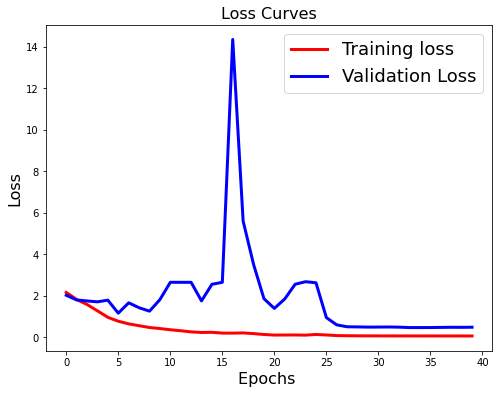

In [23]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5, 1.0, 'Accuracy Curves')

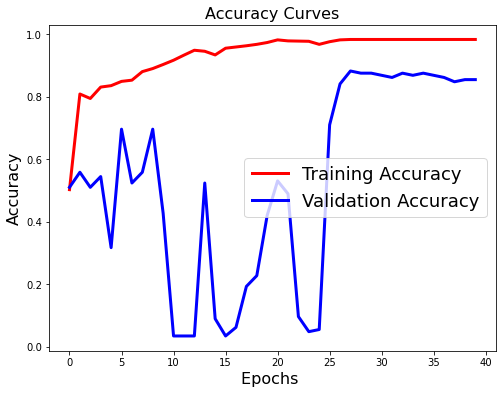

In [24]:
plt.figure(figsize=[8,6])
plt.plot(history.history['categorical_accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_categorical_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)